# Capítulo 7 – Detección de Anomalías con One-Class SVM

En este capítulo se presenta el algoritmo **One-Class Support Vector Machine (One-Class SVM)**, una técnica no supervisada para la detección de anomalías basada en el marco de las máquinas de vectores de soporte.

Su fortaleza principal reside en que **aprende una frontera en el espacio de características que encierra la mayor parte de los datos considerados normales**, de modo que todo lo que quede fuera se interpreta como una anomalía.

## ¿Por qué One-Class SVM?

La elección de One-Class SVM responde a varios motivos:

- Es un modelo **matemáticamente sólido**, derivado de las Máquinas de Vectores de Soporte.
- Puede modelar **fronteras no lineales complejas** mediante *kernels* como el RBF.
- Funciona sin necesidad de etiquetas, lo que lo hace adecuado en contextos industriales donde no se dispone de clasificaciones fiables.
- Permite un control explícito sobre el **porcentaje esperado de anomalías** mediante el hiperparámetro $\nu$.

## Intuición

El One-Class SVM busca encontrar un **hiperplano en el espacio de características** que maximice la separación entre los datos normales y el origen.

De forma intuitiva:

> One-Class SVM encierra la nube de puntos normales dentro de una frontera flexible. Todo lo que se salga de esa frontera se considera anómalo.

## Fundamento Teórico

El One-Class SVM se formula como un problema de optimización:

$$
\min_{\mathbf{w},\,\rho,\,\boldsymbol{\xi}} \quad \frac{1}{2}\,\lVert \mathbf{w} \rVert^2 \;+\; \frac{1}{\nu n}\sum_{i=1}^{n} \xi_i \;-\; \rho
$$

Sujeto a:

$$
\langle \mathbf{w}, \,\phi(x_i) \rangle \;\ge\; \rho \;-\; \xi_i,\quad \xi_i \ge 0,\quad i = 1,\dots,n
$$

Donde:

- $\phi(x)$: transformación (implícita) del espacio de características mediante el *kernel*.
- $\mathbf{w}$: vector de pesos en el espacio transformado.
- $\rho$: umbral que define la frontera.
- $\nu \in (0,1]$: parámetro que controla la fracción de *outliers* y el número de vectores de soporte.

La función de decisión resultante es:

$$
f(x) \;=\; \operatorname{sign}\!\big(\,\langle \mathbf{w}, \phi(x) \rangle \;-\; \rho\,\big)
$$

## Función de Decisión y *Scores*

- **Salida de predicción**: $f(x) \in \{+1,\,-1\}$
  - $+1$ → punto normal
  - $-1$ → anómalo

- **Score de decisión**: valores continuos que indican qué tan lejos está el punto de la frontera.
  - Valores grandes y positivos → normales con alta confianza.
  - Valores cercanos a $0$ → puntos ambiguos.
  - Valores negativos → anomalías.

## Parámetros Clave

- **$\nu$ (nu)**: fracción máxima de anomalías esperadas (típicamente entre $0.01$ y $0.1$).
- **`kernel`**: define la forma de la frontera (el más usado es RBF).
- **$\gamma$ (gamma)**: controla la influencia local en *kernels* RBF/polinomial/sigmoide.
- **`coef0`**: relevante en *kernels* polinomiales o sigmoides.


## Implementación de One-Class SVM

A continuación implementamos un detector de anomalías basado en **One-Class SVM**.  
El objetivo es envolver la mayor parte de los datos "normales" dentro de una frontera flexible definida por el kernel.

La implementación se apoya en `scikit-learn`, pero se encapsula en una clase propia para mantener una interfaz consistente con el resto de modelos de este trabajo (`fit`, `predict`, `anomaly_score`).


In [7]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

from modelos.base import BaseAnomalyDetector

class OneClassSVMDetector(BaseAnomalyDetector):
    def __init__(self, nu=0.05, kernel="rbf", gamma="scale"):
        """
        Detector de anomalías basado en One-Class SVM.

        Parámetros
        ----------
        nu : float, opcional (default=0.05)
            Fracción de outliers esperados en los datos.
        kernel : str, opcional (default="rbf")
            Tipo de kernel a utilizar ("linear", "rbf", "poly", "sigmoid").
        gamma : {"scale", "auto"} o float, opcional (default="scale")
            Parámetro del kernel RBF/polinómico/sigmoide.
        """
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma
        self.is_fitted = False

        self.model = OneClassSVM(nu=self.nu, kernel=self.kernel, gamma=self.gamma)
        self.scaler = StandardScaler()

    def preprocess(self, X, retrain=True):
        """Estandariza los datos para que todas las variables estén en la misma escala."""
        X = np.asarray(X, dtype=np.float32)
        if self.scaler:
            if retrain:
                return self.scaler.fit_transform(X)
            else:
                return self.scaler.transform(X)
        return X

    def fit(self, X):
        """Entrena el modelo One-Class SVM sobre los datos X."""
        Xp = self.preprocess(X, retrain=True)
        self.model.fit(Xp)
        self.is_fitted = True
        return self

    def predict(self, X, y=None):
        """
        Predice etiquetas para los datos X.
        Devuelve 1 para anomalía, 0 para normal.
        """
        if not self.is_fitted:
            raise RuntimeError("El modelo debe ser entrenado con fit() antes de predecir.")
        Xp = self.preprocess(X, retrain=False)
        y_pred = self.model.predict(Xp)
        return np.where(y_pred == -1, 1, 0)  # -1 → anomalía, 1 → normal

    def anomaly_score(self, X, y=None):
        """
        Devuelve un score continuo de anomalía.
        Valores más altos indican mayor probabilidad de anomalía.
        """
        if not self.is_fitted:
            raise RuntimeError("El modelo debe ser entrenado con fit() antes de calcular scores.")
        Xp = self.preprocess(X, retrain=False)
        scores = self.model.decision_function(Xp)
        return -scores  # Negativo para que anomalías tengan score alto

### Ejemplo visual en 2D

Para ilustrar cómo funciona One-Class SVM vamos a construir un dataset artificial muy sencillo:

- Una nube de puntos normales alrededor del centro (0,0).
- Algunos puntos alejados que jugarán el papel de anomalías.

Entrenaremos One-Class SVM **solo con los normales** (como es habitual en escenarios no supervisados) y luego veremos:

1. Cómo se forma la **frontera de decisión** alrededor de la nube.
2. Qué puntos quedan dentro (normales) y fuera (anómalos).


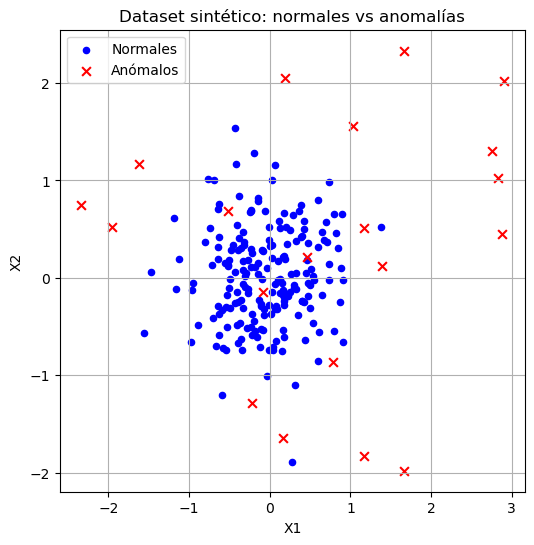

In [8]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

# Datos normales: nube circular alrededor del origen
X_norm = rng.normal(loc=0, scale=0.5, size=(200, 2))

# Anomalías: lejos del centro
X_out = rng.uniform(low=-3, high=3, size=(20, 2))

X = np.vstack([X_norm, X_out])
y_true = np.hstack([np.zeros(len(X_norm)), np.ones(len(X_out))])  # 0=normal, 1=anómalo

plt.figure(figsize=(6,6))
plt.scatter(X_norm[:,0], X_norm[:,1], c="blue", s=20, label="Normales")
plt.scatter(X_out[:,0], X_out[:,1], c="red", s=40, marker="x", label="Anómalos")
plt.legend()
plt.title("Dataset sintético: normales vs anomalías")
plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


### Entrenamiento del modelo

Entrenamos un One-Class SVM **solo con los puntos normales**.  
Después, proyectaremos la frontera de decisión sobre el plano para ver qué región considera "normal".


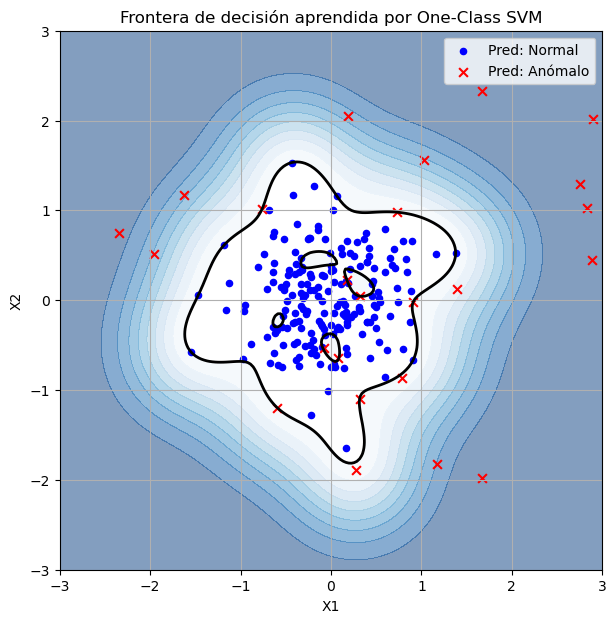

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Escalamos datos
scaler = StandardScaler()
X_norm_scaled = scaler.fit_transform(X_norm)
X_all_scaled = scaler.transform(X)

# Entrenamos One-Class SVM con kernel RBF
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
ocsvm.fit(X_norm_scaled)

# Grid para dibujar la frontera
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)

Z = ocsvm.decision_function(grid_scaled)
Z = Z.reshape(xx.shape)

# Predicciones
y_pred = ocsvm.predict(X_all_scaled)

# Visualización
plt.figure(figsize=(7,7))
# Frontera
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
# Área normal
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r, alpha=0.5)
# Datos
plt.scatter(X[y_pred==1,0], X[y_pred==1,1], c="blue", s=20, label="Pred: Normal")
plt.scatter(X[y_pred==-1,0], X[y_pred==-1,1], c="red", s=40, marker="x", label="Pred: Anómalo")
plt.legend()
plt.title("Frontera de decisión aprendida por One-Class SVM")
plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


### Explorando parámetros

El comportamiento de One-Class SVM depende sobre todo de dos hiperparámetros:

- **ν (nu):** controla la fracción máxima de anomalías que se espera encontrar.  
  Valores grandes → frontera más restrictiva (más puntos detectados como anomalías).  
  Valores pequeños → frontera más amplia (menos anomalías).  

- **γ (gamma):** controla la flexibilidad del kernel RBF.  
  Valores grandes → frontera muy ondulada y ajustada a los datos.  
  Valores pequeños → frontera suave y amplia.  

Veamos gráficamente cómo cambian las fronteras al variar estos parámetros.


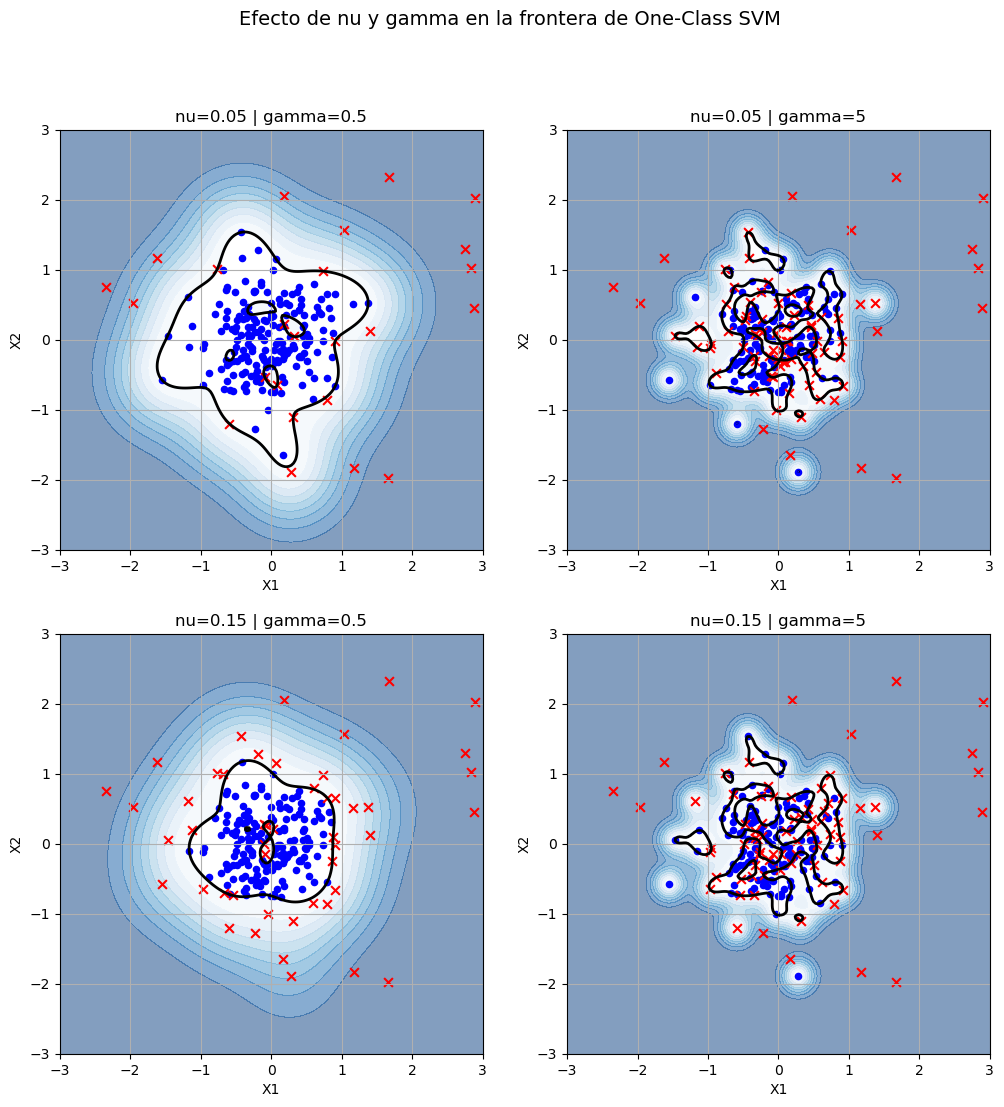

In [10]:
params = [
    {"nu":0.05, "gamma":0.5},
    {"nu":0.05, "gamma":5},
    {"nu":0.15, "gamma":0.5},
    {"nu":0.15, "gamma":5},
]

fig, axes = plt.subplots(2,2,figsize=(12,12))

for ax, p in zip(axes.ravel(), params):
    ocsvm = OneClassSVM(nu=p["nu"], kernel="rbf", gamma=p["gamma"])
    ocsvm.fit(X_norm_scaled)
    Z = ocsvm.decision_function(grid_scaled).reshape(xx.shape)
    y_pred = ocsvm.predict(X_all_scaled)

    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r, alpha=0.5)
    ax.scatter(X[y_pred==1,0], X[y_pred==1,1], c="blue", s=20)
    ax.scatter(X[y_pred==-1,0], X[y_pred==-1,1], c="red", s=40, marker="x")
    ax.set_title(f"nu={p['nu']} | gamma={p['gamma']}")
    ax.set_xlabel("X1"); ax.set_ylabel("X2"); ax.grid(True)

plt.suptitle("Efecto de nu y gamma en la frontera de One-Class SVM", fontsize=14)
plt.show()


### Scores de anomalía

Además de clasificar los puntos como normales o anómalos, One-Class SVM devuelve un **score continuo**:

- Valores positivos → puntos dentro de la frontera (normales).  
- Valores cercanos a 0 → puntos en la frontera (casos ambiguos).  
- Valores negativos → puntos fuera de la frontera (anómalos).  

Podemos representar estos scores como un mapa de calor para entender mejor cómo interpreta el modelo el espacio de características.


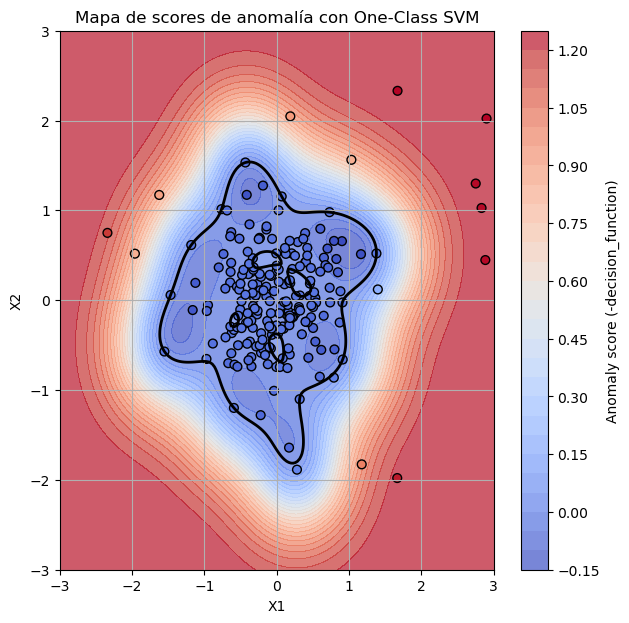

In [11]:
# Entrenamos un modelo base
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.5)
ocsvm.fit(X_norm_scaled)

# Calculamos scores sobre el grid
Z = ocsvm.decision_function(grid_scaled).reshape(xx.shape)

# Scores sobre los puntos reales
scores = ocsvm.decision_function(X_all_scaled)

plt.figure(figsize=(7,7))
# Fondo coloreado por score
scores_anomaly = -scores  # invertir
Z_anomaly = -Z

cs = plt.contourf(xx, yy, Z_anomaly, levels=30, cmap="coolwarm", alpha=0.7)
plt.colorbar(cs, label="Anomaly score (-decision_function)")
plt.scatter(X[:,0], X[:,1], c=scores_anomaly, cmap="coolwarm", edgecolors="k", s=40)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
plt.title("Mapa de scores de anomalía con One-Class SVM")
plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


### Interpretación de los scores

- **Centro azul** → valores positivos y grandes: puntos bien dentro de la región normal.  
- **Zona blanca/amarilla** → valores cercanos a 0: frontera del modelo.  
- **Zona roja** → valores negativos: puntos anómalos, fuera de la región.  

Esta visión es útil porque permite establecer umbrales **post-hoc** sobre los scores, ajustando la sensibilidad del detector según las necesidades del problema.


### Comparación de kernels en One-Class SVM

El comportamiento de One-Class SVM depende en gran parte del **kernel** utilizado, que define la forma de la frontera en el espacio de características:

- **Linear**: frontera lineal, adecuada si los datos se separan aproximadamente por un hiperplano.  
- **Polynomial**: fronteras polinómicas, más flexibles, pero sensibles al grado del polinomio.  
- **Sigmoid**: genera fronteras similares a las redes neuronales clásicas, aunque menos usado en la práctica.  
- **RBF (Radial Basis Function)**: frontera curva y suave que se adapta bien a relaciones no lineales.  

Para señales y sistemas físicos donde las relaciones entre variables suelen ser **no lineales y complejas**, el kernel **RBF** suele ser la opción más robusta.


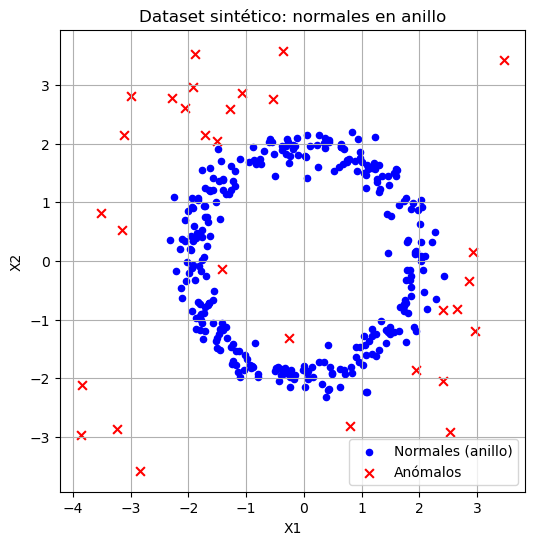

In [12]:
# Dataset en forma de anillo: normales = círculo, anomalías = dispersos fuera
theta = rng.uniform(0, 2*np.pi, 300)
r = rng.normal(2.0, 0.2, 300)  # radio con ruido
X_ring = np.c_[r * np.cos(theta), r * np.sin(theta)]

X_out_ring = rng.uniform(low=-4, high=4, size=(30, 2))
X_all = np.vstack([X_ring, X_out_ring])
y_true = np.hstack([np.zeros(len(X_ring)), np.ones(len(X_out_ring))])  # 0=normal, 1=anómalo

plt.figure(figsize=(6,6))
plt.scatter(X_ring[:,0], X_ring[:,1], c="blue", s=20, label="Normales (anillo)")
plt.scatter(X_out_ring[:,0], X_out_ring[:,1], c="red", s=40, marker="x", label="Anómalos")
plt.legend()
plt.title("Dataset sintético: normales en anillo")
plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


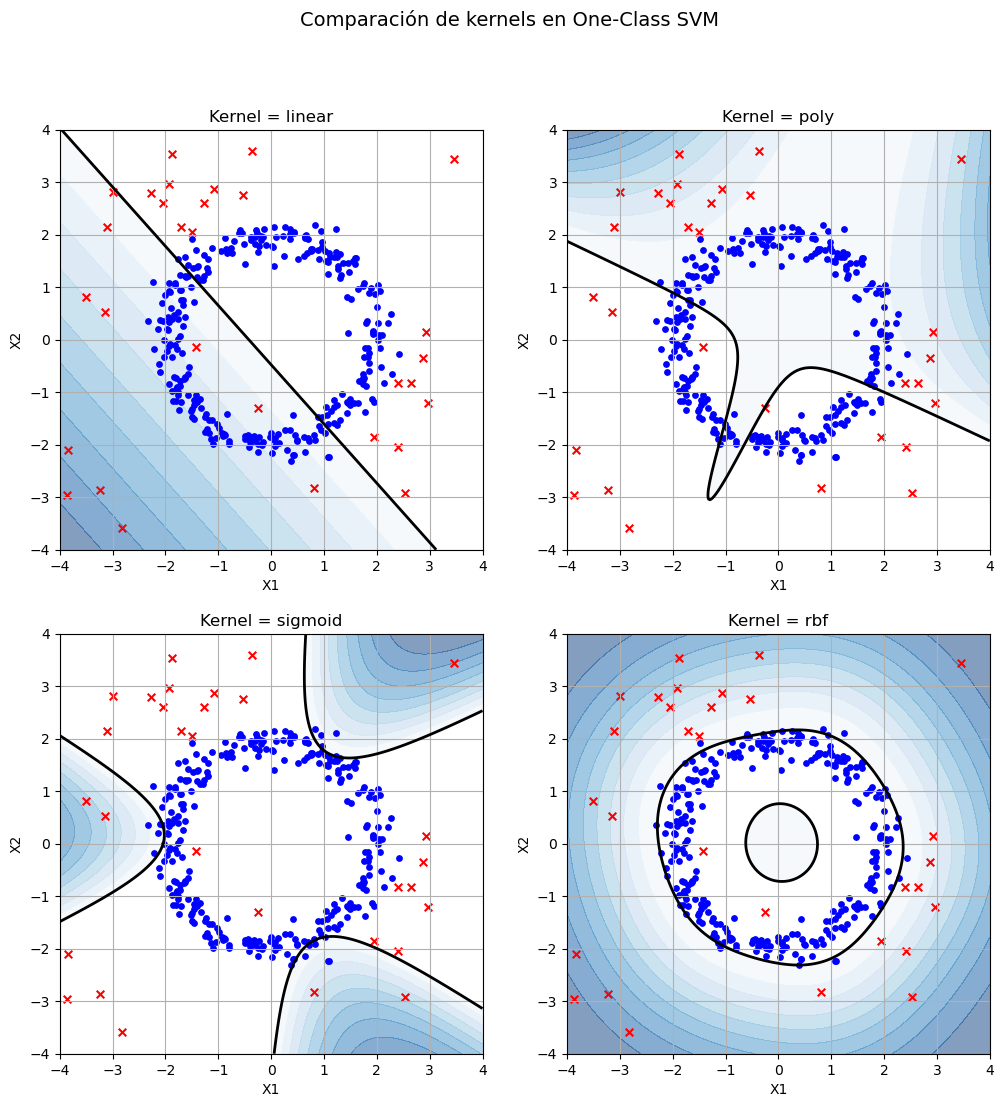

In [13]:
kernels = ["linear", "poly", "sigmoid", "rbf"]

fig, axes = plt.subplots(2,2,figsize=(12,12))

for ax, k in zip(axes.ravel(), kernels):
    ocsvm = OneClassSVM(nu=0.05, kernel=k, gamma="scale")
    ocsvm.fit(StandardScaler().fit_transform(X_ring))

    # Grid
    xx, yy = np.meshgrid(np.linspace(-4, 4, 300), np.linspace(-4, 4, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = StandardScaler().fit(X_ring).transform(grid)
    Z = ocsvm.decision_function(grid_scaled).reshape(xx.shape)

    # Dibujar frontera
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r, alpha=0.5)
    ax.scatter(X_ring[:,0], X_ring[:,1], c="blue", s=15)
    ax.scatter(X_out_ring[:,0], X_out_ring[:,1], c="red", s=30, marker="x")
    ax.set_title(f"Kernel = {k}")
    ax.set_xlabel("X1"); ax.set_ylabel("X2"); ax.grid(True)

plt.suptitle("Comparación de kernels en One-Class SVM", fontsize=14)
plt.show()


### Sobre los kernels

- **Linear**: solo puede generar fronteras rectas → no consigue encerrar el anillo.  
- **Polynomial**: puede encerrar regiones, pero su forma depende fuertemente del grado y tiende a ser inestable.  
- **Sigmoid**: comportamiento intermedio, pero poco usado porque no ofrece claras ventajas.  
- **RBF**: logra una frontera suave y cerrada alrededor del anillo, adaptándose a la forma no lineal.  

En la práctica, para **señales reales y relaciones no lineales entre variables**, el kernel **RBF** es la opción más adecuada y la que se emplea por defecto en la mayoría de aplicaciones.


## Conclusión

One-Class SVM ofrece un enfoque sólido para la detección de anomalías: en lugar de aislar puntos, como hace Isolation Forest, **aprende la frontera que delimita lo normal** en el espacio de características.  

Su capacidad para trabajar con *kernels* lo hace muy flexible, especialmente con RBF, que resulta ideal en señales con relaciones no lineales. Sin embargo, esta potencia viene acompañada de sensibilidad al escalado y a la elección de hiperparámetros como $\nu$ y $\gamma$.  

Este equilibrio entre **teoría bien fundamentada** y **reto práctico de ajuste** convierte a One-Class SVM en una pieza clave en la caja de herramientas de la detección de anomalías, aunque su escalabilidad pueda ser limitada en comparación con métodos basados en árboles.  

El siguiente paso será explorar modelos de **aprendizaje profundo**, capaces de representar estructuras aún más complejas sin depender tanto de la elección de kernel.


---

## Referencias

Schölkopf, Bernhard, et al.  
*Estimating the support of a high-dimensional distribution.* Neural computation 13.7 (2001): 1443-1471.  

Tax, David MJ, and Robert PW Duin.  
*Support vector data description.* Machine learning 54 (2004): 45-66.  